# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.utils import *
from pybatina.advanced_weight_recovery import *

In [3]:
guess_range=(-5.0, 5.0)

## Recover multiple secret numbers

In [4]:
SECRET_VALUE='secret value'
GUESSED_VALUE = 'guessed value'
CORRELATION='correlation'
TIME='exec. time'
df_index = [SECRET_VALUE, GUESSED_VALUE, CORRELATION, TIME]

In [5]:
precision = 1e-3
n_secret_numbers = 5000
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
)).astype(np.float32)
np.random.shuffle(secret_numbers)
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

secret_numbers.shape = (5000,)


## Batina without noise

In [6]:
from os import path
wr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=30)
fname = path.join(TEST_RESULT_DIR, 'advanced_results_%s_%d.csv' % (''.join(['%02d' % i for i in wr.MANTISSA_THREE_BYTES]), wr.number_of_best_candidates))
print('fname =', fname)

fname = ./results/advanced_results_100805_30.csv


### load existing DB

In [7]:
# read the existing data
try:
    last_df = pd.read_csv(fname, index_col=0)
    print('read results in %s' % fname)
    print('number of weight values', len(last_df[SECRET_VALUE].unique()))
except FileNotFoundError:
    last_df = pd.DataFrame()
    pass

#last_df = pd.DataFrame()
batina_results = last_df

read results in ./results/advanced_results_100805_30.csv
number of weight values 3343


### main process

In [8]:
%%time 

import time

for value in secret_numbers:
    try:
        if value in batina_results[SECRET_VALUE].unique():
            continue
    except KeyError:
        pass
    secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * value) for input_values in wr.input_value_set]    
    start_time = time.time()
    s = wr.recover_weight(secret_hamming_weight_set)    
    stop_time = time.time()
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': GUESSED_VALUE})
    df[TIME] = stop_time - start_time
    df[SECRET_VALUE] = value
    batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

<timed exec>:9: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
../pybatina/advanced_weight_recovery.py:208: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
../pybatina/advanced_weight_recovery.py:208: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


KeyboardInterrupt: 

In [9]:
batina_results

,guessed value,correlation,secret value,exec. time
0,1.091812,1.000000,1.091812,0.000000
1,1.091812,0.956010,1.091812,0.000000
2,1.091812,0.955862,1.091812,0.000000
3,1.091816,0.901422,1.091812,0.000000
4,1.091816,0.886878,1.091812,0.000000
...,...,...,...,...
102085,0.074222,0.494070,0.074326,14.761721
102086,0.074466,0.491333,0.074326,14.761721
102087,0.074344,0.487602,0.074326,14.761721
102088,0.074405,0.484223,0.074326,14.761721


### merge and save DB

In [10]:
print('number of weight values', len(batina_results[SECRET_VALUE].unique()))
batina_results.to_csv(fname)
print('save results in %s' % fname)

number of weight values 3401
save results in ./results/advanced_results_100805_30.csv


### Statistics

In [11]:
ERROR = 'error'
def statistics(df):
    dft = df[df_index].astype(dtype=np.float64)
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])    
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [12]:
batina_best_corr, batina_best_err = statistics(batina_results)

In [13]:
study_score = batina_best_corr
(study_score.T[ERROR] < 1e-3).value_counts()

True     3397
False       4
Name: error, dtype: int64

In [14]:
error_sorted = study_score.T.sort_values(ERROR, ascending=False)
error_sorted[:20]

,secret value,guessed value,correlation,exec. time,error
93510,4.974066,0.019430,1.000000,13.976947,0.996094
74070,2.687558,3.833986,0.716374,0.000000,0.426568
8880,0.744873,0.979493,0.820149,0.000000,0.314980
24540,-0.499909,-0.499273,0.779921,0.000000,0.001272
30060,-0.124942,-0.124847,0.683184,0.000000,0.000767
43590,-0.499645,-0.499291,0.805292,0.000000,0.000710
18210,-3.997897,-3.995795,0.930473,0.000000,0.000526
34350,4.001888,4.000007,0.820444,0.000000,0.000470
10110,-0.250025,-0.250122,0.928795,0.000000,0.000387
42840,-4.000631,-4.001954,0.840811,0.000000,0.000331


In [15]:
error_sorted.iloc[0][SECRET_VALUE]

4.974065780639648

save results in ./results/advanced_batina_graphs.jpg


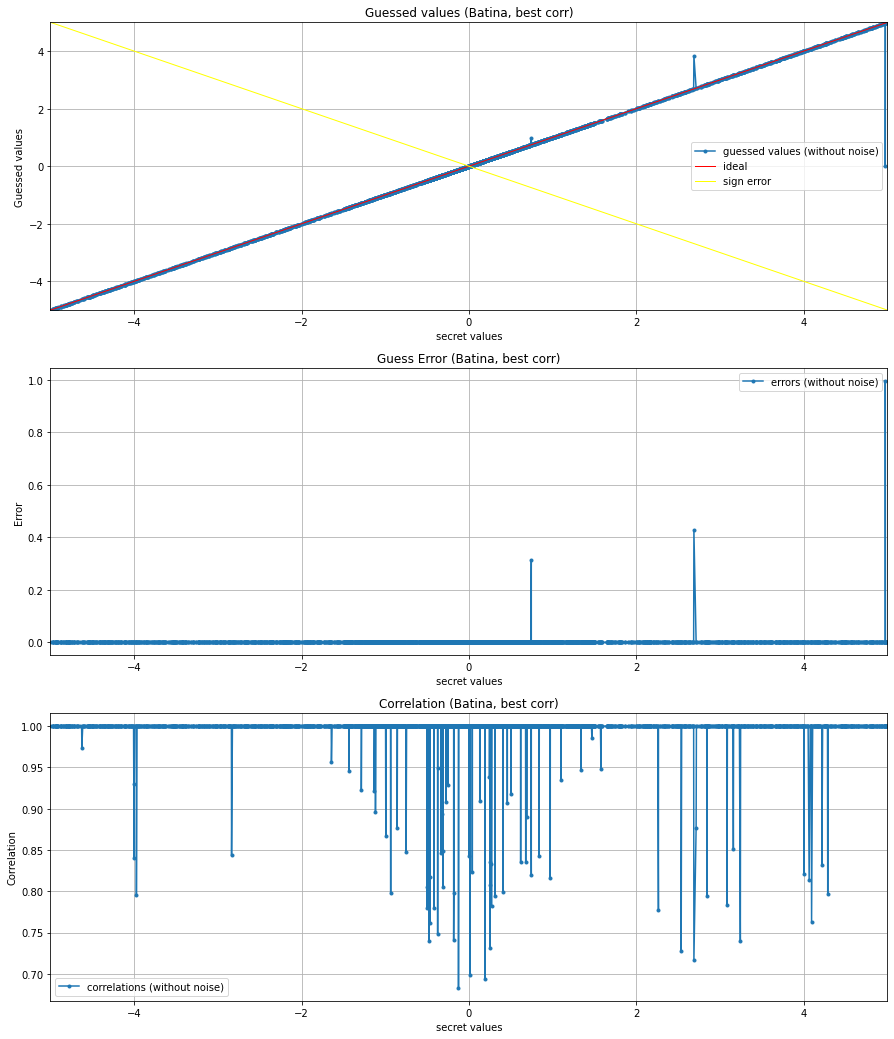

In [16]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='guessed values (without noise)')
ax[0].plot(guess_range, guess_range, linewidth=1, label='ideal', color='red')
ax[0].plot([guess_range[1], guess_range[0]], guess_range, linewidth=1, label='sign error', color='yellow')
ax[0].set_ylim(np.min(guess_range), np.max(guess_range))

ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr)')

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='errors (without noise)')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr)')

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='correlations (without noise)')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr)')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')
    a.set_xlim(np.min(guess_range), np.max(guess_range))

from os import path
fig_fname = path.join(TEST_RESULT_DIR, 'advanced_batina_graphs.jpg')
plt.savefig(fig_fname)
print('save results in %s' % fig_fname)
plt.show()